In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [3]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)


def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [4]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("creditcard.csv")
assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

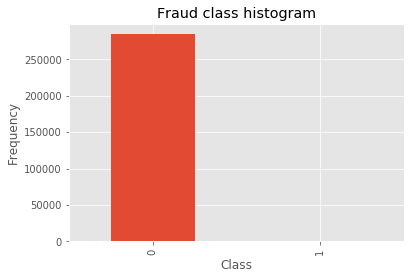

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [6]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [7]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


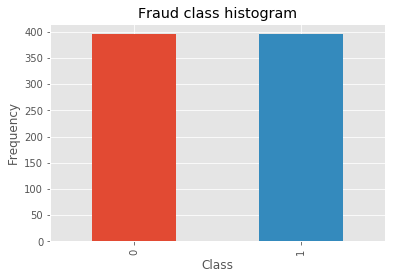

0    395
1    395
Name: Class, dtype: int64

In [8]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [9]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [10]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss)
        print("Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        for i in range(self.epochs):
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [11]:
# k-fold validation with k=5
k_fold_split_array = k_fold_split_data(under_sample_dataset, 5)
models = []
for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = train[:, :-1]
    y_train = train[:, -1:]

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)
    
    print("\n", '='*80)
    print("Validation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)

Loss: 

0.198739759109

Accuracy: 

0.7294303797468354

Loss: 

0.197500629406

Accuracy: 

0.7310126582278481

Loss: 

0.195757365456

Accuracy: 

0.7341772151898734

Loss: 

0.193615832332

Accuracy: 

0.7357594936708861

Loss: 

0.191176894908

Accuracy: 

0.740506329113924

Loss: 

0.188524349323

Accuracy: 

0.740506329113924

Loss: 

0.185723429219

Accuracy: 

0.745253164556962

Loss: 

0.182824301094

Accuracy: 

0.7484177215189873

Loss: 

0.179864915325

Accuracy: 

0.7531645569620253

Loss: 

0.176872017453

Accuracy: 

0.7563291139240507

Loss: 

0.173861501158

Accuracy: 

0.7610759493670886

Loss: 

0.170839041635

Accuracy: 

0.7642405063291139

Loss: 

0.167802838668

Accuracy: 

0.7689873417721519

Loss: 

0.164749039863

Accuracy: 

0.7721518987341772

Loss: 

0.161676445157

Accuracy: 

0.7737341772151899

Loss: 

0.1585834837

Accuracy: 

0.7800632911392406

Loss: 

0.155458752521

Accuracy: 

0.7832278481012658

Loss: 

0.152287218611

Accuracy: 

0.7848101265822784

Loss: 

0.149089220999

Accuracy: 

0.7895569620253164

Loss: 

0.145954391171

Accuracy: 

0.7990506329113924

Loss: 

0.142987988545

Accuracy: 

0.805379746835443

Loss: 

0.140192910907

Accuracy: 

0.805379746835443

Loss: 

0.137463666025

Accuracy: 

0.805379746835443

Loss: 

0.134687155791

Accuracy: 

0.8085443037974683

Loss: 

0.131806137986

Accuracy: 

0.8132911392405063

Loss: 

0.128834041231

Accuracy: 

0.8180379746835443

Loss: 

0.125840072201

Accuracy: 

0.8291139240506329

Loss: 

0.122890503575

Accuracy: 

0.8338607594936709

Loss: 

0.119997743735

Accuracy: 

0.8433544303797469

Loss: 

0.117139199265

Accuracy: 

0.8560126582278481

Loss: 

0.114295889486

Accuracy: 

0.865506329113924

Loss: 

0.111462762006

Accuracy: 

0.870253164556962

Loss: 

0.108643585167

Accuracy: 

0.8781645569620253

Loss: 

0.105845646132

Accuracy: 

0.879746835443038

Loss: 

0.103077171973

Accuracy: 

0.884493670886076

Loss: 

0.100346732774

Accuracy: 

0.8829113924050633

Loss: 

0.0976628528862

Accuracy: 

0.8813291139240507

Loss: 

0.095034089465

Accuracy: 

0.884493670886076

Loss: 

0.0924689509304

Accuracy: 

0.8908227848101266

Loss: 

0.0899758712027

Accuracy: 

0.8939873417721519

Loss: 

0.0875629384343

Accuracy: 

0.8987341772151899

Loss: 

0.0852377601919

Accuracy: 

0.9034810126582279

Loss: 

0.0830073111642

Accuracy: 

0.9018987341772152

Loss: 

0.0808775210661

Accuracy: 

0.9018987341772152

Loss: 

0.0788534140206

Accuracy: 

0.9066455696202531

Loss: 

0.0769389775838

Accuracy: 

0.9066455696202531

Loss: 

0.0751372384079

Accuracy: 

0.9129746835443038

Loss: 

0.0734503466441

Accuracy: 

0.9113924050632911

Loss: 

0.0718796405699

Accuracy: 

0.9129746835443038

Loss: 

0.0704256592303

Accuracy: 

0.9145569620253164

Loss: 

0.0690880313828

Accuracy: 

0.9161392405063291

Loss: 

0.067865372002

Accuracy: 

0.9177215189873418

Loss: 

0.0667550561622

Accuracy: 

0.9177215189873418

Loss: 

0.0657530825526

Accuracy: 

0.9177215189873418

Loss: 

0.0648541097338

Accuracy: 

0.9161392405063291

Loss: 

0.0640515230707

Accuracy: 

0.9177215189873418

Loss: 

0.0633377933749

Accuracy: 

0.9177215189873418

Loss: 

0.0627048385135

Accuracy: 

0.9208860759493671

Loss: 

0.0621444606285

Accuracy: 

0.9224683544303798

Loss: 

0.0616486929093

Accuracy: 

0.9224683544303798

Loss: 

0.0612101240426

Accuracy: 

0.9224683544303798

Loss: 

0.0608220552421

Accuracy: 

0.9224683544303798

Loss: 

0.0604785729947

Accuracy: 

0.9224683544303798

Loss: 

0.0601745504488

Accuracy: 

0.9240506329113924

Loss: 

0.0599055775725

Accuracy: 

0.9256329113924051

Loss: 

0.0596678584027

Accuracy: 

0.9256329113924051

Loss: 

0.059458115155

Accuracy: 

0.9256329113924051

Loss: 

0.0592734992495

Accuracy: 

0.9272151898734177

Loss: 

0.0591114985432

Accuracy: 

0.9272151898734177

Loss: 

0.0589698828044

Accuracy: 

0.9272151898734177

Loss: 

0.0588466500857

Accuracy: 

0.9287974683544303

Loss: 

0.0587399995756

Accuracy: 

0.9287974683544303

Loss: 

0.0586482723502

Accuracy: 

0.9287974683544303

Loss: 

0.0585699500118

Accuracy: 

0.9287974683544303

Loss: 

0.0585036109549

Accuracy: 

0.9272151898734177

Loss: 

0.0584479764103

Accuracy: 

0.9272151898734177

Loss: 

0.058401875454

Accuracy: 

0.9287974683544303

Loss: 

0.0583642593108

Accuracy: 

0.9287974683544303

Loss: 

0.0583341063875

Accuracy: 

0.9287974683544303

Loss: 

0.0583105014627

Accuracy: 

0.9287974683544303

Validation dataset evaluation:

Loss: 

0.0383110278416

Accuracy: 

0.9556962025316456

Loss: 

0.441743796106

Accuracy: 

0.3987341772151899

Loss: 

0.436855879761

Accuracy: 

0.40664556962025317

Loss: 

0.429138481806

Accuracy: 

0.4050632911392405

Loss: 

0.418147344992

Accuracy: 

0.41930379746835444

Loss: 

0.403369855595

Accuracy: 

0.43354430379746833

Loss: 

0.383415935876

Accuracy: 

0.4525316455696203

Loss: 

0.353328043747

Accuracy: 

0.47151898734177217

Loss: 

0.304943654354

Accuracy: 

0.5174050632911392

Loss: 

0.246668343554

Accuracy: 

0.6123417721518988

Loss: 

0.206405758222

Accuracy: 

0.6629746835443038

Loss: 

0.188268139672

Accuracy: 

0.6835443037974683

Loss: 

0.182315451622

Accuracy: 

0.6977848101265823

Loss: 

0.181791417476

Accuracy: 

0.6819620253164557

Loss: 

0.183787988232

Accuracy: 

0.6772151898734177

Loss: 

0.18676285767

Accuracy: 

0.6582278481012658

Loss: 

0.189988351153

Accuracy: 

0.6503164556962026

Loss: 

0.193116099347

Accuracy: 

0.6503164556962026

Loss: 

0.19596465263

Accuracy: 

0.6392405063291139

Loss: 

0.198434748005

Accuracy: 

0.6376582278481012

Loss: 

0.20047005496

Accuracy: 

0.6360759493670886

Loss: 

0.202037305211

Accuracy: 

0.634493670886076

Loss: 

0.20311608359

Accuracy: 

0.6329113924050633

Loss: 

0.203693675996

Accuracy: 

0.6329113924050633

Loss: 

0.20376252789

Accuracy: 

0.6313291139240507

Loss: 

0.203318940291

Accuracy: 

0.6313291139240507

Loss: 

0.202362509375

Accuracy: 

0.6329113924050633

Loss: 

0.200895923048

Accuracy: 

0.6360759493670886

Loss: 

0.198924971598

Accuracy: 

0.6392405063291139

Loss: 

0.196458650027

Accuracy: 

0.6455696202531646

Loss: 

0.193509382021

Accuracy: 

0.6518987341772152

Loss: 

0.190093278066

Accuracy: 

0.6598101265822784

Loss: 

0.186230372962

Accuracy: 

0.6645569620253164

Loss: 

0.181944912592

Accuracy: 

0.6740506329113924

Loss: 

0.177265541745

Accuracy: 

0.6819620253164557

Loss: 

0.172225415795

Accuracy: 

0.6930379746835443

Loss: 

0.166862165684

Accuracy: 

0.7104430379746836

Loss: 

0.161217689083

Accuracy: 

0.7215189873417721

Loss: 

0.155337869206

Accuracy: 

0.7420886075949367

Loss: 

0.149272001653

Accuracy: 

0.7579113924050633

Loss: 

0.143072149936

Accuracy: 

0.7753164556962026

Loss: 

0.136792288662

Accuracy: 

0.7879746835443038

Loss: 

0.130487275468

Accuracy: 

0.805379746835443

Loss: 

0.124211781102

Accuracy: 

0.819620253164557

Loss: 

0.118019153972

Accuracy: 

0.8370253164556962

Loss: 

0.111960182869

Accuracy: 

0.8449367088607594

Loss: 

0.106082003428

Accuracy: 

0.8575949367088608

Loss: 

0.100427071849

Accuracy: 

0.865506329113924

Loss: 

0.0950323460571

Accuracy: 

0.879746835443038

Loss: 

0.089928805564

Accuracy: 

0.8892405063291139

Loss: 

0.0851412972929

Accuracy: 

0.8971518987341772

Loss: 

0.0806887908459

Accuracy: 

0.9050632911392406

Loss: 

0.076584822598

Accuracy: 

0.9129746835443038

Loss: 

0.0728381484354

Accuracy: 

0.9145569620253164

Loss: 

0.0694531710202

Accuracy: 

0.9193037974683544

Loss: 

0.0664300792942

Accuracy: 

0.9287974683544303

Loss: 

0.0637647497188

Accuracy: 

0.9272151898734177

Loss: 

0.0614483695601

Accuracy: 

0.9287974683544303

Loss: 

0.059467221715

Accuracy: 

0.9240506329113924

Loss: 

0.057802923784

Accuracy: 

0.930379746835443

Loss: 

0.0564332143935

Accuracy: 

0.930379746835443

Loss: 

0.0553333163712

Accuracy: 

0.9319620253164557

Loss: 

0.0544771617942

Accuracy: 

0.9319620253164557

Loss: 

0.0538388652632

Accuracy: 

0.9272151898734177

Loss: 

0.0533936229849

Accuracy: 

0.9287974683544303

Loss: 

0.0531182798016

Accuracy: 

0.930379746835443

Loss: 

0.0529915440758

Accuracy: 

0.9319620253164557

Loss: 

0.0529940314592

Accuracy: 

0.9335443037974683

Loss: 

0.0531081389736

Accuracy: 

0.9335443037974683

Loss: 

0.0533179593652

Accuracy: 

0.9335443037974683

Loss: 

0.0536091955475

Accuracy: 

0.930379746835443

Loss: 

0.0539691078151

Accuracy: 

0.9319620253164557

Loss: 

0.0543865057986

Accuracy: 

0.9319620253164557

Loss: 

0.0548517446964

Accuracy: 

0.9319620253164557

Loss: 

0.0553566765

Accuracy: 

0.930379746835443

Loss: 

0.0558945885089

Accuracy: 

0.930379746835443

Loss: 

0.0564600698381

Accuracy: 

0.930379746835443

Loss: 

0.0570487671947

Accuracy: 

0.930379746835443

Loss: 

0.0576571286531

Accuracy: 

0.930379746835443

Loss: 

0.0582821049142

Accuracy: 

0.930379746835443

Loss: 

0.0589208337932

Accuracy: 

0.930379746835443

Validation dataset evaluation:

Loss: 

0.0607948000858

Accuracy: 

0.9113924050632911

Loss: 

0.278620163751

Accuracy: 

0.6313291139240507

Loss: 

0.244394390337

Accuracy: 

0.6835443037974683

Loss: 

0.210091917754

Accuracy: 

0.7325949367088608

Loss: 

0.177226834775

Accuracy: 

0.7768987341772152

Loss: 

0.148845967841

Accuracy: 

0.8306962025316456

Loss: 

0.132839996522

Accuracy: 

0.8465189873417721

Loss: 

0.126035404237

Accuracy: 

0.8465189873417721

Loss: 

0.123272968021

Accuracy: 

0.8401898734177216

Loss: 

0.12261035771

Accuracy: 

0.8306962025316456

Loss: 

0.123001549204

Accuracy: 

0.8259493670886076

Loss: 

0.123967150772

Accuracy: 

0.8180379746835443

Loss: 

0.125332017251

Accuracy: 

0.8180379746835443

Loss: 

0.12702529764

Accuracy: 

0.8117088607594937

Loss: 

0.128987284326

Accuracy: 

0.810126582278481

Loss: 

0.131144461081

Accuracy: 

0.8085443037974683

Loss: 

0.133412305097

Accuracy: 

0.7974683544303798

Loss: 

0.135703763106

Accuracy: 

0.7895569620253164

Loss: 

0.137935621718

Accuracy: 

0.7816455696202531

Loss: 

0.140031906675

Accuracy: 

0.7784810126582279

Loss: 

0.141925366552

Accuracy: 

0.7784810126582279

Loss: 

0.14355794558

Accuracy: 

0.7705696202531646

Loss: 

0.144880702284

Accuracy: 

0.7674050632911392

Loss: 

0.145853495461

Accuracy: 

0.7626582278481012

Loss: 

0.1464445293

Accuracy: 

0.7579113924050633

Loss: 

0.146629801596

Accuracy: 

0.759493670886076

Loss: 

0.146392587921

Accuracy: 

0.7579113924050633

Loss: 

0.145722944812

Accuracy: 

0.754746835443038

Loss: 

0.144617283368

Accuracy: 

0.754746835443038

Loss: 

0.143078042163

Accuracy: 

0.7626582278481012

Loss: 

0.141113396757

Accuracy: 

0.7753164556962026

Loss: 

0.138737051528

Accuracy: 

0.7800632911392406

Loss: 

0.135968061774

Accuracy: 

0.7943037974683544

Loss: 

0.132830680187

Accuracy: 

0.8037974683544303

Loss: 

0.129354191152

Accuracy: 

0.8132911392405063

Loss: 

0.12557264774

Accuracy: 

0.8275316455696202

Loss: 

0.1215246159

Accuracy: 

0.8417721518987342

Loss: 

0.117252742148

Accuracy: 

0.8544303797468354

Loss: 

0.112803197736

Accuracy: 

0.8560126582278481

Loss: 

0.108224919635

Accuracy: 

0.875

Loss: 

0.103568684963

Accuracy: 

0.879746835443038

Loss: 

0.0988860593623

Accuracy: 

0.8829113924050633

Loss: 

0.0942282007914

Accuracy: 

0.8892405063291139

Loss: 

0.0896446650194

Accuracy: 

0.9018987341772152

Loss: 

0.0851822480963

Accuracy: 

0.9082278481012658

Loss: 

0.0808839944814

Accuracy: 

0.9129746835443038

Loss: 

0.0767884433213

Accuracy: 

0.9240506329113924

Loss: 

0.072929148404

Accuracy: 

0.9256329113924051

Loss: 

0.0693343869838

Accuracy: 

0.9272151898734177

Loss: 

0.0660270055937

Accuracy: 

0.930379746835443

Loss: 

0.0630242373963

Accuracy: 

0.9287974683544303

Loss: 

0.0603373839102

Accuracy: 

0.9319620253164557

Loss: 

0.0579712564252

Accuracy: 

0.9319620253164557

Loss: 

0.0559237028111

Accuracy: 

0.9335443037974683

Loss: 

0.0541854974351

Accuracy: 

0.9335443037974683

Loss: 

0.0527408599431

Accuracy: 

0.9319620253164557

Loss: 

0.0515686853248

Accuracy: 

0.9335443037974683

Loss: 

0.050644137357

Accuracy: 

0.9335443037974683

Loss: 

0.0499402894688

Accuracy: 

0.935126582278481

Loss: 

0.0494296043947

Accuracy: 

0.9335443037974683

Loss: 

0.049085169222

Accuracy: 

0.9319620253164557

Loss: 

0.0488816434666

Accuracy: 

0.9319620253164557

Loss: 

0.0487959127696

Accuracy: 

0.935126582278481

Loss: 

0.0488074247586

Accuracy: 

0.935126582278481

Loss: 

0.0488982805789

Accuracy: 

0.935126582278481

Loss: 

0.0490531292612

Accuracy: 

0.935126582278481

Loss: 

0.049258961902

Accuracy: 

0.9382911392405063

Loss: 

0.0495048486441

Accuracy: 

0.9382911392405063

Loss: 

0.0497816716333

Accuracy: 

0.9367088607594937

Loss: 

0.0500818694206

Accuracy: 

0.9367088607594937

Loss: 

0.0503991998759

Accuracy: 

0.9367088607594937

Loss: 

0.050728522612

Accuracy: 

0.9367088607594937

Loss: 

0.0510656075385

Accuracy: 

0.935126582278481

Loss: 

0.0514070315839

Accuracy: 

0.935126582278481

Loss: 

0.0517499881632

Accuracy: 

0.935126582278481

Loss: 

0.0520921948339

Accuracy: 

0.935126582278481

Loss: 

0.052431813463

Accuracy: 

0.935126582278481

Loss: 

0.0527673462489

Accuracy: 

0.935126582278481

Loss: 

0.0530975786464

Accuracy: 

0.935126582278481

Loss: 

0.0534215680835

Accuracy: 

0.935126582278481

Loss: 

0.0537385771692

Accuracy: 

0.935126582278481

Validation dataset evaluation:

Loss: 

0.0697218720452

Accuracy: 

0.9113924050632911

Loss: 

0.223796541379

Accuracy: 

0.6408227848101266

Loss: 

0.213321805953

Accuracy: 

0.6439873417721519

Loss: 

0.199565376006

Accuracy: 

0.6534810126582279

Loss: 

0.186112465865

Accuracy: 

0.6756329113924051

Loss: 

0.177011705956

Accuracy: 

0.6835443037974683

Loss: 

0.173215692869

Accuracy: 

0.6882911392405063

Loss: 

0.171927394363

Accuracy: 

0.685126582278481

Loss: 

0.171277176417

Accuracy: 

0.6867088607594937

Loss: 

0.170806919242

Accuracy: 

0.685126582278481

Loss: 

0.170359305482

Accuracy: 

0.6835443037974683

Loss: 

0.169839429881

Accuracy: 

0.689873417721519

Loss: 

0.169177814346

Accuracy: 

0.6914556962025317

Loss: 

0.168319666741

Accuracy: 

0.6930379746835443

Loss: 

0.167220904006

Accuracy: 

0.6930379746835443

Loss: 

0.165847040177

Accuracy: 

0.694620253164557

Loss: 

0.164172931269

Accuracy: 

0.694620253164557

Loss: 

0.162182528402

Accuracy: 

0.7056962025316456

Loss: 

0.159868365803

Accuracy: 

0.7136075949367089

Loss: 

0.157230849838

Accuracy: 

0.7231012658227848

Loss: 

0.154277548584

Accuracy: 

0.7325949367088608

Loss: 

0.151022513373

Accuracy: 

0.745253164556962

Loss: 

0.147485704052

Accuracy: 

0.7579113924050633

Loss: 

0.143692482956

Accuracy: 

0.7737341772151899

Loss: 

0.139673143162

Accuracy: 

0.7816455696202531

Loss: 

0.135462393956

Accuracy: 

0.7879746835443038

Loss: 

0.13109879249

Accuracy: 

0.8037974683544303

Loss: 

0.126624090102

Accuracy: 

0.8180379746835443

Loss: 

0.122082390881

Accuracy: 

0.8322784810126582

Loss: 

0.117519182918

Accuracy: 

0.8449367088607594

Loss: 

0.112980213054

Accuracy: 

0.8607594936708861

Loss: 

0.108510206581

Accuracy: 

0.8813291139240507

Loss: 

0.104151533128

Accuracy: 

0.8892405063291139

Loss: 

0.099942942473

Accuracy: 

0.8924050632911392

Loss: 

0.0959185031915

Accuracy: 

0.8939873417721519

Loss: 

0.092106866415

Accuracy: 

0.9003164556962026

Loss: 

0.0885309644986

Accuracy: 

0.9177215189873418

Loss: 

0.0852081084015

Accuracy: 

0.9208860759493671

Loss: 

0.0821503656674

Accuracy: 

0.9208860759493671

Loss: 

0.0793650141339

Accuracy: 

0.9224683544303798

Loss: 

0.0768548961867

Accuracy: 

0.9256329113924051

Loss: 

0.0746185353356

Accuracy: 

0.9272151898734177

Loss: 

0.0726500904154

Accuracy: 

0.930379746835443

Loss: 

0.0709392676114

Accuracy: 

0.9287974683544303

Loss: 

0.0694715112244

Accuracy: 

0.9287974683544303

Loss: 

0.068228547598

Accuracy: 

0.9256329113924051

Loss: 

0.0671893762907

Accuracy: 

0.9256329113924051

Loss: 

0.0663314474897

Accuracy: 

0.9272151898734177

Loss: 

0.0656317839576

Accuracy: 

0.9272151898734177

Loss: 

0.0650679441925

Accuracy: 

0.9256329113924051

Loss: 

0.0646186725815

Accuracy: 

0.9240506329113924

Loss: 

0.0642642944984

Accuracy: 

0.9240506329113924

Loss: 

0.063986954663

Accuracy: 

0.9240506329113924

Loss: 

0.0637707019753

Accuracy: 

0.9240506329113924

Loss: 

0.0636014252046

Accuracy: 

0.9240506329113924

Loss: 

0.0634668608543

Accuracy: 

0.9240506329113924

Loss: 

0.0633564615915

Accuracy: 

0.9240506329113924

Loss: 

0.0632613158136

Accuracy: 

0.9240506329113924

Loss: 

0.0631740448398

Accuracy: 

0.9240506329113924

Loss: 

0.0630886628459

Accuracy: 

0.9240506329113924

Loss: 

0.0630004307112

Accuracy: 

0.9240506329113924

Loss: 

0.0629057839717

Accuracy: 

0.9240506329113924

Loss: 

0.0628022019098

Accuracy: 

0.9240506329113924

Loss: 

0.0626880409057

Accuracy: 

0.9240506329113924

Loss: 

0.0625624356794

Accuracy: 

0.9240506329113924

Loss: 

0.0624251874356

Accuracy: 

0.9240506329113924

Loss: 

0.0622766330568

Accuracy: 

0.9240506329113924

Loss: 

0.0621175277557

Accuracy: 

0.9240506329113924

Loss: 

0.0619489345918

Accuracy: 

0.9240506329113924

Loss: 

0.0617721274342

Accuracy: 

0.9240506329113924

Loss: 

0.0615885046211

Accuracy: 

0.9240506329113924

Loss: 

0.0613994889774

Accuracy: 

0.9240506329113924

Loss: 

0.0612064979393

Accuracy: 

0.9240506329113924

Loss: 

0.061010891282

Accuracy: 

0.9256329113924051

Loss: 

0.0608139795744

Accuracy: 

0.9256329113924051

Loss: 

0.0606168938934

Accuracy: 

0.9256329113924051

Loss: 

0.0604206858037

Accuracy: 

0.9256329113924051

Loss: 

0.0602262930334

Accuracy: 

0.9272151898734177

Loss: 

0.0600345604666

Accuracy: 

0.9287974683544303

Loss: 

0.0598462385284

Accuracy: 

0.9287974683544303

Loss: 

0.0596619885315

Accuracy: 

0.9287974683544303

Validation dataset evaluation:

Loss: 

0.0829687968913

Accuracy: 

0.9113924050632911

Loss: 

0.249839979989

Accuracy: 

0.5981012658227848

Loss: 

0.247201336156

Accuracy: 

0.6028481012658228

Loss: 

0.243682552074

Accuracy: 

0.6091772151898734

Loss: 

0.239681615432

Accuracy: 

0.6186708860759493

Loss: 

0.235571366059

Accuracy: 

0.6265822784810127

Loss: 

0.231627207554

Accuracy: 

0.6360759493670886

Loss: 

0.227992125427

Accuracy: 

0.6408227848101266

Loss: 

0.224696534964

Accuracy: 

0.6471518987341772

Loss: 

0.221705074972

Accuracy: 

0.6518987341772152

Loss: 

0.218951321508

Accuracy: 

0.6534810126582279

Loss: 

0.216354995609

Accuracy: 

0.6566455696202531

Loss: 

0.213832119063

Accuracy: 

0.6582278481012658

Loss: 

0.211302436554

Accuracy: 

0.6582278481012658

Loss: 

0.208694578202

Accuracy: 

0.6613924050632911

Loss: 

0.205948754186

Accuracy: 

0.6629746835443038

Loss: 

0.203017397868

Accuracy: 

0.6677215189873418

Loss: 

0.199864576669

Accuracy: 

0.6756329113924051

Loss: 

0.196464874124

Accuracy: 

0.6882911392405063

Loss: 

0.192802160639

Accuracy: 

0.6882911392405063

Loss: 

0.18886854567

Accuracy: 

0.694620253164557

Loss: 

0.184663550017

Accuracy: 

0.6962025316455697

Loss: 

0.18019353122

Accuracy: 

0.6977848101265823

Loss: 

0.175471330038

Accuracy: 

0.7088607594936709

Loss: 

0.17051602153

Accuracy: 

0.7183544303797469

Loss: 

0.165352565238

Accuracy: 

0.7231012658227848

Loss: 

0.160011414785

Accuracy: 

0.7357594936708861

Loss: 

0.154527857213

Accuracy: 

0.7468354430379747

Loss: 

0.148940988991

Accuracy: 

0.7563291139240507

Loss: 

0.143292508436

Accuracy: 

0.7705696202531646

Loss: 

0.137625284783

Accuracy: 

0.7863924050632911

Loss: 

0.131982037089

Accuracy: 

0.805379746835443

Loss: 

0.126404200606

Accuracy: 

0.8180379746835443

Loss: 

0.120931223729

Accuracy: 

0.8259493670886076

Loss: 

0.115600259866

Accuracy: 

0.8449367088607594

Loss: 

0.1104464311

Accuracy: 

0.8544303797468354

Loss: 

0.10550384612

Accuracy: 

0.865506329113924

Loss: 

0.100807720339

Accuracy: 

0.879746835443038

Loss: 

0.0963982120392

Accuracy: 

0.8781645569620253

Loss: 

0.092325729708

Accuracy: 

0.884493670886076

Loss: 

0.0886546911531

Accuracy: 

0.8892405063291139

Loss: 

0.0854573961037

Accuracy: 

0.8939873417721519

Loss: 

0.0827877557768

Accuracy: 

0.8971518987341772

Loss: 

0.0806432267656

Accuracy: 

0.9066455696202531

Loss: 

0.0789528723304

Accuracy: 

0.9034810126582279

Loss: 

0.0776117224498

Accuracy: 

0.9018987341772152

Loss: 

0.0765264342722

Accuracy: 

0.9018987341772152

Loss: 

0.0756344770453

Accuracy: 

0.9018987341772152

Loss: 

0.0748990802165

Accuracy: 

0.9034810126582279

Loss: 

0.0742975981788

Accuracy: 

0.9034810126582279

Loss: 

0.0738125750154

Accuracy: 

0.9034810126582279

Loss: 

0.0734268805931

Accuracy: 

0.9034810126582279

Loss: 

0.0731213862759

Accuracy: 

0.9050632911392406

Loss: 

0.0728743762947

Accuracy: 

0.9034810126582279

Loss: 

0.072662344417

Accuracy: 

0.9034810126582279

Loss: 

0.0724605991949

Accuracy: 

0.9034810126582279

Loss: 

0.0722439736657

Accuracy: 

0.9034810126582279

Loss: 

0.0719878943706

Accuracy: 

0.9034810126582279

Loss: 

0.0716678318655

Accuracy: 

0.9034810126582279

Loss: 

0.0712589584057

Accuracy: 

0.9034810126582279

Loss: 

0.0707370488769

Accuracy: 

0.9034810126582279

Loss: 

0.0700834344841

Accuracy: 

0.9066455696202531

Loss: 

0.0692973735575

Accuracy: 

0.9098101265822784

Loss: 

0.0684155024071

Accuracy: 

0.9098101265822784

Loss: 

0.0675235021836

Accuracy: 

0.9177215189873418

Loss: 

0.0667302504307

Accuracy: 

0.9193037974683544

Loss: 

0.0661056136636

Accuracy: 

0.9193037974683544

Loss: 

0.0656454230008

Accuracy: 

0.9208860759493671

Loss: 

0.065300065575

Accuracy: 

0.9224683544303798

Loss: 

0.0650199280589

Accuracy: 

0.9208860759493671

Loss: 

0.0647739192544

Accuracy: 

0.9208860759493671

Loss: 

0.0645470984729

Accuracy: 

0.9208860759493671

Loss: 

0.0643335364489

Accuracy: 

0.9256329113924051

Loss: 

0.0641313494565

Accuracy: 

0.9256329113924051

Loss: 

0.0639402109418

Accuracy: 

0.9256329113924051

Loss: 

0.0637602467247

Accuracy: 

0.9287974683544303

Loss: 

0.0635916701484

Accuracy: 

0.9287974683544303

Loss: 

0.0634345425985

Accuracy: 

0.9287974683544303

Loss: 

0.0632887755012

Accuracy: 

0.9287974683544303

Loss: 

0.0631540718641

Accuracy: 

0.9287974683544303

Loss: 

0.0630299494842

Accuracy: 

0.9287974683544303

Validation dataset evaluation:

Loss: 

0.0505187450828

Accuracy: 

0.9430379746835443

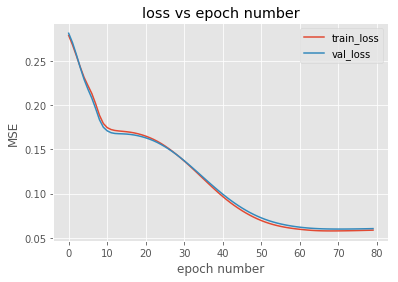

In [12]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [13]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:

Loss: 

0.442245077873

Accuracy: 

0.5025316455696203

Loss: 

0.439760756268

Accuracy: 

0.5025316455696203

Loss: 

0.43577297023

Accuracy: 

0.5050632911392405

Loss: 

0.429912338414

Accuracy: 

0.5063291139240507

Loss: 

0.421587886341

Accuracy: 

0.5101265822784811

Loss: 

0.409871325735

Accuracy: 

0.5126582278481012

Loss: 

0.393336683377

Accuracy: 

0.5240506329113924

Loss: 

0.370056272171

Accuracy: 

0.5392405063291139

Loss: 

0.338082344155

Accuracy: 

0.5620253164556962

Loss: 

0.293270888104

Accuracy: 

0.6164556962025316

Loss: 

0.225575429949

Accuracy: 

0.6835443037974683

Loss: 

0.154216322823

Accuracy: 

0.8075949367088607

Loss: 

0.12389318549

Accuracy: 

0.8645569620253165

Loss: 

0.113250059429

Accuracy: 

0.8620253164556962

Loss: 

0.107527937862

Accuracy: 

0.859493670886076

Loss: 

0.106889646983

Accuracy: 

0.8607594936708861

Loss: 

0.111952709032

Accuracy: 

0.8455696202531645

Loss: 

0.11861323071

Accuracy: 

0.8240506329113924

Loss: 

0.125512357262

Accuracy: 

0.8063291139240506

Loss: 

0.132463648359

Accuracy: 

0.789873417721519

Loss: 

0.13934069906

Accuracy: 

0.7670886075949367

Loss: 

0.14604182778

Accuracy: 

0.7506329113924051

Loss: 

0.152481804406

Accuracy: 

0.7443037974683544

Loss: 

0.158588629743

Accuracy: 

0.7265822784810126

Loss: 

0.164301890767

Accuracy: 

0.7139240506329114

Loss: 

0.169571533299

Accuracy: 

0.7025316455696202

Loss: 

0.174356693844

Accuracy: 

0.6949367088607595

Loss: 

0.178624561835

Accuracy: 

0.6873417721518987

Loss: 

0.182349406086

Accuracy: 

0.6797468354430379

Loss: 

0.185511760414

Accuracy: 

0.6759493670886076

Loss: 

0.188097810313

Accuracy: 

0.6734177215189874

Loss: 

0.190098884343

Accuracy: 

0.669620253164557

Loss: 

0.191511002818

Accuracy: 

0.6683544303797468

Loss: 

0.192334426553

Accuracy: 

0.6658227848101266

Loss: 

0.192573267401

Accuracy: 

0.6670886075949367

Loss: 

0.192235148315

Accuracy: 

0.6708860759493671

Loss: 

0.191330914612

Accuracy: 

0.6746835443037975

Loss: 

0.189874490175

Accuracy: 

0.6810126582278481

Loss: 

0.18788282722

Accuracy: 

0.6873417721518987

Loss: 

0.185375988747

Accuracy: 

0.6936708860759494

Loss: 

0.182377284543

Accuracy: 

0.7050632911392405

Loss: 

0.178913479057

Accuracy: 

0.7126582278481013

Loss: 

0.175015024426

Accuracy: 

0.7265822784810126

Loss: 

0.170716240922

Accuracy: 

0.7367088607594937

Loss: 

0.166055367877

Accuracy: 

0.7443037974683544

Loss: 

0.161074423481

Accuracy: 

0.7544303797468355

Loss: 

0.155818794442

Accuracy: 

0.7658227848101266

Loss: 

0.150336562123

Accuracy: 

0.7772151898734178

Loss: 

0.144677574901

Accuracy: 

0.789873417721519

Loss: 

0.138892393846

Accuracy: 

0.8063291139240506

Loss: 

0.133031215997

Accuracy: 

0.8189873417721519

Loss: 

0.127142914136

Accuracy: 

0.8278481012658228

Loss: 

0.12127428387

Accuracy: 

0.8379746835443038

Loss: 

0.115469481755

Accuracy: 

0.8468354430379746

Loss: 

0.10976966727

Accuracy: 

0.8531645569620253

Loss: 

0.104212873096

Accuracy: 

0.859493670886076

Loss: 

0.0988339113887

Accuracy: 

0.8670886075949367

Loss: 

0.0936642386084

Accuracy: 

0.8759493670886076

Loss: 

0.088731504518

Accuracy: 

0.8835443037974684

Loss: 

0.0840587345399

Accuracy: 

0.8936708860759494

Loss: 

0.079663332099

Accuracy: 

0.9037974683544304

Loss: 

0.0755563557457

Accuracy: 

0.9037974683544304

Loss: 

0.071742594204

Accuracy: 

0.9088607594936708

Loss: 

0.0682216369013

Accuracy: 

0.9126582278481012

Loss: 

0.0649897457994

Accuracy: 

0.9164556962025316

Loss: 

0.0620421904542

Accuracy: 

0.9189873417721519

Loss: 

0.0593753948207

Accuracy: 

0.920253164556962

Loss: 

0.0569884666336

Accuracy: 

0.9227848101265823

Loss: 

0.0548831006105

Accuracy: 

0.9265822784810127

Loss: 

0.0530608740147

Accuracy: 

0.9291139240506329

Loss: 

0.0515180026806

Accuracy: 

0.930379746835443

Loss: 

0.0502399943093

Accuracy: 

0.9329113924050633

Loss: 

0.0492006389807

Accuracy: 

0.9379746835443038

Loss: 

0.0483673779471

Accuracy: 

0.9367088607594937

Loss: 

0.0477094836883

Accuracy: 

0.9367088607594937

Loss: 

0.0472035655268

Accuracy: 

0.9354430379746835

Loss: 

0.046834240105

Accuracy: 

0.9341772151898734

Loss: 

0.0465916786462

Accuracy: 

0.9379746835443038

Loss: 

0.0464686161749

Accuracy: 

0.9379746835443038

Loss: 

0.0464581418997

Accuracy: 

0.9379746835443038

In [23]:
test = pd.read_csv("test_dataset.csv", index_col=False)
print(test.info())
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56962 entries, 0 to 56961
Data columns (total 29 columns):
V1       56962 non-null float64
V2       56962 non-null float64
V3       56962 non-null float64
V4       56962 non-null float64
V5       56962 non-null float64
V6       56962 non-null float64
V7       56962 non-null float64
V8       56962 non-null float64
V9       56962 non-null float64
V10      56962 non-null float64
V11      56962 non-null float64
V12      56962 non-null float64
V13      56962 non-null float64
V14      56962 non-null float64
V15      56962 non-null float64
V16      56962 non-null float64
V17      56962 non-null float64
V18      56962 non-null float64
V19      56962 non-null float64
V20      56962 non-null float64
V21      56962 non-null float64
V22      56962 non-null float64
V23      56962 non-null float64
V24      56962 non-null float64
V25      56962 non-null float64
V26      56962 non-null float64
V27      56962 non-null float64
V28      56962 non-null flo

None

Loss: 

0.0391538480063

Accuracy: 

0.9561110916049296


Precision: 0.2186046511627907

Recall: 0.8785046728971962

F-score: 0.3500931098696462

             actual 1  actual 0
predicted 1        94       336
predicted 0        13     56519

100%|██████████| 21/21 [00:56<00:00,  2.68s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


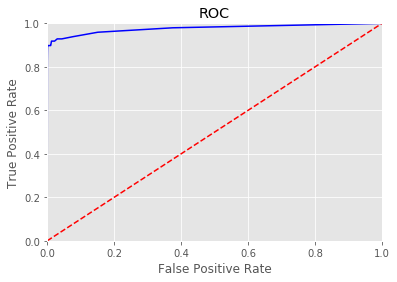

In [117]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)